<a href="https://colab.research.google.com/github/stcoats/phonetics_pipeline/blob/main/YouTube_phonetics_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Install dependencies and import**

In [ ]:
import os

if not os.path.exists('/content/phonetics_pipeline'):
  os.mkdir('/content/phonetics_pipeline')

%cd /content/phonetics_pipeline/

!pip install -U praat-parselmouth
!pip install -U pydub
!pip install -U yt-dlp
!pip install -U static-ffmpeg
!pip install -U webvtt-py
!pip install -U colab-xterm 
!pip install -U praat-textgrids
!pip install -U adjustText 

/content/phonetics_pipeline
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import parselmouth
import pandas as pd
from parselmouth.praat import call
from pydub import AudioSegment
import glob
import yt_dlp
from yt_dlp.utils import download_range_func
import pickle
import requests
import os
import re
import numpy as np
import pathlib
import static_ffmpeg
import webvtt
import glob
import html
import spacy
nlp = spacy.load("en_core_web_sm")

**Step 2: Get ASR transcripts from a YT channel**

In [ ]:
#Click on the stop button to end the downloading, otherwise it will attempt to retrieve all the transcripts in the channel

outpt = []

for x in ["https://www.youtube.com/@CityofGallatin"]:    #This is the channel of Gallatin, Tennessee, USA.
# The script will try to get all of the videos with ASR transcripts in the channel (~740, as of May 2023)
# The list can contain multiple channels 
# A list of single videos just needs the video IDs, for example ["GQFF4lD7rgk","-p9GfpbY-DY"]

        ydl_opts = {
                 'writeautomaticsub': True, #This will retrieve the YT-generated Automatic Speech Recognition transcript (not manual transcripts/captions)
                'subtitlelangs':'.en\-orig', #This retrieves only English-language transcripts and prevents download of transcripts automatically translated into English from another language 
                'outtmpl': '/content/phonetics_pipeline/%(uploader)s/%(upload_date)s--%(id)s--%(title)s.%(ext)s', #Here we are using yt-dl syntax to capture the channel name, upload date, video id, video title, and file extension
                'skip_download':True,
                'ignoreerrors': True,
                'sleep_interval':4,
            }

        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                        try:
                            items = ydl.extract_info(x)
                        except:
                            continue


[youtube:tab] Extracting URL: https://www.youtube.com/@CityofGallatin
[youtube:tab] @CityofGallatin: Downloading webpage
[youtube:tab] Downloading all uploads of the channel. To download only the videos in a specific tab, pass the tab's URL
[youtube:tab] @CityofGallatin/streams: Downloading webpage
[youtube:tab] @CityofGallatin/shorts: Downloading webpage
[youtube:tab] Downloading as multiple playlists, separated by tabs. To download as a single playlist instead, pass https://www.youtube.com/playlist?list=UUtAYSfBFVBAXZd__rLdXwrg
[download] Downloading playlist: CityofGallatin
[youtube:tab] Playlist CityofGallatin: Downloading 3 items of 3
[download] Downloading item 1 of 3
[download] Downloading playlist: CityofGallatin - Videos
[youtube:tab] UCtAYSfBFVBAXZd__rLdXwrg page 1: Downloading API JSON
[youtube:tab] UCtAYSfBFVBAXZd__rLdXwrg page 2: Downloading API JSON
[youtube:tab] UCtAYSfBFVBAXZd__rLdXwrg page 3: Downloading API JSON
[youtube:tab] UCtAYSfBFVBAXZd__rLdXwrg page 4: Downloadi

**Step 3: Functions to convert the ASR transcripts to standard text or to text with timing information on each token**

In [ ]:
#Caption getter: The input is a single .vtt transcript file
#The output is a string containing the text of the transcript 

def remove_adjacent(nums):
     return [a for a,b in zip(nums, nums[1:]+[not nums[-1]]) if a != b]

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return round(int(h) * 3600 + int(m) * 60 + float(s),2)

def caption_getter(vid):
    items = vid.split("/")[3:]
    channel_name = items[0]
    names = items[-1].split("--")
    upload_date = names[0]
    video_title = names[2].replace(".en.vtt","").replace(".en-orig.vtt","")  
    video_id = names[1]
    stripped1=[]
    captions = webvtt.read(vid)
    ends = []
    for caption in captions:
        ends.append(caption.end)
        stripped = caption.text.replace('\n', "\n")
        stripped1.append(stripped.split("\n"))
        text_transcript = [x for y in stripped1 for x in y if x != " "]
        text_transcript1 = " ".join(remove_adjacent(text_transcript))
        #caption1 = re.sub("\n","",caption.text).strip()
    return channel_name, video_id,video_title,upload_date,max([get_sec(x) for x in ends]),text_transcript1
                  



In [ ]:
#Timed caption getter: The input is a single .vtt transcript file
#The output is a string containing the text of the transcript with timing information attached to each token with the form token_123.45
#Tokens can also include a PoS tag (token_POS_123.45)
#See the comments in the code below

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return round(int(h) * 3600 + int(m) * 60 + float(s),2)

def timed_caption_getter(vid):
    items = vid.split("/")[3:]
    channel_name = items[0]
    names = items[-1].split("--")
    upload_date = names[0]
    video_title = names[2].replace(".en.vtt","").replace(".en-orig.vtt","")  
    video_id = names[1]  
    captions = webvtt.read(vid)
    ends = []
    text_transcript = []
    for caption in captions:
        ends.append(caption.end)
        caption_unescaped= html.unescape(caption.start+caption.raw_text+caption.end)
        text_transcript.extend(re.findall("(<?\s?\d\d\:\d\d\:\d\d\.\d\d\d>?)?([\[\w+](?:[\w'-\.\&\%]+?)?[^\<]?)?(?:<?/c.*?>){0,3}(<?\s?\d\d\:\d\d\:\d\d\.\d\d\d>?)",caption_unescaped))
    tt = [x for x in text_transcript if x[1] != "" and not "\n" in x[1]]
    text_timed_transcript = " ".join([v[1]+"_"+str(get_sec(v[2].replace("<","").replace(">",""))) for v in tt])
    return channel_name, video_id,video_title,upload_date,max([get_sec(x) for x in ends]),text_timed_transcript
    

    #To add the PoS tags, comment out the two lines immediately above and uncomment the lines below!

    #nlp = spacy.load("en_core_web_sm")
    #doc = spacy.tokens.doc.Doc(nlp.vocab, words=[x[1] for x in tt])
    #for name, proc in nlp.pipeline:
    #    doc = proc(doc)
    #tags = [z.tag_ for z in doc]
    #text_timedpos_transcript = " ".join([v[1]+"_"+tags[i]+"_"+str(get_sec(v[2].replace("<","").replace(">",""))) for i,v in enumerate(tt)])
    #return channel_name, video_id,video_title,upload_date,max([get_sec(x) for x in ends]),text_timedpos_transcript

**Step 4: Make a data frame from the transcripts**

In [ ]:
#If you are only interested in the text of the transcript, and not the timing information, use the caption_getter function instead of timed_caption_getter

vids = glob.glob("/content/phonetics_pipeline/CityofGallatin/*.vtt")
vids_list = []
for y in vids:
  vids_list.append(timed_caption_getter(y))

vids_df = pd.DataFrame(vids_list)
vids_df.columns = ["channel_name",
                          "video_id","video_title","upload_date",
                             "video_length","text",
                           ]
vids_df

,channel_name,video_id,video_title,upload_date,video_length,text
0,CityofGallatin,9tI34_tKLmA,12-6-22 Gallatin City Council Meeting,20230123,3689.84,good_JJ_136.86 evening_NN_137.04 everyone_NN_1...
1,CityofGallatin,2zpFvo9j5Kw,Shalom Mural Reveal,20230117,810.92,my_PRP$_0.9 name_NN_1.08 is_VBZ_1.32 Tara_NNP_...
2,CityofGallatin,Bcc2f6WauVU,Leadership Gallatin Visits the Fire Department,20230215,57.68,okay_UH_3.67 leadership_NN_4.68 Gallatin_NNP_5...
3,CityofGallatin,mPKuGA60wwI,Station Camp HS Creates Flower Baskets for Cit...,20230302,127.10,occasionally_RB_1.86 if_IN_2.16 someone's_NNS_...
4,CityofGallatin,-y9XSc_DMUQ,Mayor Brown Turns on Cairo Signals,20230426,72.33,hi_UH_1.02 everyone_NN_1.26 Paige_NNP_1.92 Bro...
5,CityofGallatin,nIAz3dubTD4,MOBE Shalom Zone Mural,20230118,71.90,a_DT_2.34 little_JJ_2.52 little_JJ_3.48 boy_NN...
6,CityofGallatin,Ucv7Qx0QHHE,Flower Basket Report #2,20230502,27.26,it's_PRP$_0.66 gone_VBN_0.9 really_RB_1.14 wel...
7,CityofGallatin,NiavGbGUNHo,Gallatin Night Beat Recruitment,20230123,34.29,I_PRP_1.62 always_RB_1.86 try_VBP_2.1 whenever...
8,CityofGallatin,oqJMyLm9z1g,01-10-23 Gallatin City Council Meeting,20230123,7631.60,foreign_JJ_84.01 good_JJ_85.02 evening_NN_85.1...
9,CityofGallatin,g3rM9VAdrxc,"Coordinated Traffic Lights in Gallatin, Tennessee",20230414,40.58,hey_UH_0.78 City_NNP_1.08 Gallatin_NNP_1.68 yo...


**Step 5: Get the audio for items of interest in the transcripts**

In [ ]:
#This step downloads the targeted audio and transcript segments
#In this example we are retrieving all instances of "need to" in our small corpus, plus three words to the left and right of the target
#This version works with a data frame in which tokens have the form token_1.00. For a frame where tokens have the form token_POS_1.00, change 

hits = []
for i,x in vids_df.iterrows():
    target = re.compile(r"((\w+_\S+\s){3}need_\S+\s+to_\S+\s+(\w+_\S+\s){3})",re.IGNORECASE)
    #For a larger "window", change the {3} tokens before and after to a higher number
    #For entries in which the text has the format word_POS_1.00, use:
    #target = re.compile(r"((\w+_\w+_\S+\s){3}need_\w+_\S+\s+to_\w+_\S+\s+(\w+_\w+_\S+\s){3})",re.IGNORECASE)

    if target.search(x["text"]):
        finds1 = target.findall(x["text"])
        for i,y in enumerate(finds1):
            seq = " ".join([z.split("_")[0] for z in y[0].split()[:-1]])
            time1 = float(y[0].split()[0].split("_")[-1])
            time2 = float(y[0].split()[-1].split("_")[-1])
            time_dif = float(time2)-float(time1)
            if time_dif < 7:
                pathlib.Path('/content/phonetics_pipeline/'+x["channel_name"]+'/audio').mkdir(parents=True, exist_ok=True) 
                with open('/content/phonetics_pipeline/'+x["channel_name"]+'/audio/'+x["video_id"]+'_'+str(seq)+'_'+str(i)+'.txt','w+') as f:
                    f.write(seq)
                ydl_opts = {'format':'ba[ext=m4a]/ba[ext=mp4]','overwrites' : True,'extract-audio':True,
                #To retrieve video fragments instead of audio fragments, comment out the line above and uncomment the line below
                #ydl_opts =  {'format':'bv*[ext=mp4]+ba[ext=m4a]/b[ext=mp4]/bv*+ba/b','overwrites' : True,'extract-audio':True,
                            'outtmpl': '/content/phonetics_pipeline/'+x["channel_name"]+'/audio/'+x["video_id"]+'_'+str(seq)+'_'+str(i)+'.mp4',
                            'download_ranges': download_range_func([], [(time1, time2)]),
                            'quiet':True}
                with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                    try:
                        ydl.download('https://www.youtube.com/watch?v='+x["video_id"])
                    except yt_dlp.utils.DownloadError:
                        print("An exception has been caught")
            else:
                pass

KeyboardInterrupt: ignored

In [ ]:
#We convert the .mp4 files to 16k Hz .wav for the Montreal Forced Aligner

sounds = glob.glob("/content/phonetics_pipeline/GovernmentZA/audio/*.mp4")
for y in sounds:
  wav_audio = AudioSegment.from_file(y, format="mp4")
  wav_audio = wav_audio.set_frame_rate(16000)  #This is what MFA/Kaldi expects
  wav_audio = wav_audio.set_sample_width(2)  #2 byte = 16 bit
  wav_audio.export(y.replace(".mp4",".wav"), format="wav")
  os.remove(y)

In [ ]:
#mfa
# from https://colab.research.google.com/gist/NTT123/12264d15afad861cb897f7a20a01762e/mfa-ljspeech.ipynb

%%writefile install_mfa.sh
#!/bin/bash

## a script to install Montreal Forced Aligner (MFA)

root_dir=${1:-/tmp/mfa}
mkdir -p $root_dir
cd $root_dir

# download miniconda3
wget -q --show-progress https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -b -p $root_dir/miniconda3 -f

#install MFA
$root_dir/miniconda3/bin/conda create -n aligner -c conda-forge montreal-forced-aligner -y

echo -e "\n======== DONE =========="
echo -e "\nTo activate MFA, run: source $root_dir/miniconda3/bin/activate aligner"
echo -e "\nTo delete MFA, run: rm -rf $root_dir"
echo -e "\nSee: https://montreal-forced-aligner.readthedocs.io/en/latest/aligning.html to know how to use MFA"

Overwriting install_mfa.sh


In [ ]:
# download and install mfa test
INSTALL_DIR="/tmp/mfa" # path to install directory

!bash ./install_mfa.sh {INSTALL_DIR}
!source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align --help

Miniconda3-latest-L 100%[===================>]  69.75M   169MB/s    in 0.4s    
PREFIX=/tmp/mfa/miniconda3
Unpacking payload ...
                                                                                                     
Installing base environment...



Preparing transaction: - done
Executing transaction: | done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /tmp/mfa/miniconda3
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [ ]:
# download a pretrained english acoustic model, and english lexicon
!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/raw/main/acoustic/english.zip
!wget -q --show-progress http://www.openslr.org/resources/11/librispeech-lexicon.txt

english.zip.1       100%[===================>]  14.05M  --.-KB/s    in 0.1s    
librispeech-lexicon 100%[===================>]   5.37M  6.05MB/s    in 0.9s    


In [ ]:
# see: https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner/pull/480
import re
lexicon = open("librispeech-lexicon.txt").readlines()
sp = re.compile("\s+")
with open("modified_librispeech-lexicon.txt", "w") as f:
    for line in lexicon:
        word, *phonemes = sp.split(line.strip())
        phonemes = " ".join(phonemes)
        f.write(f"{word}\t{phonemes}\n")

In [ ]:
#These models/dicts can also be used

#!source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa model download acoustic english_us_arpa
#!source {INSTALL_DIR}/miniconda3/bin/activate aligner;mfa model download dictionary english_us_arpa

 INFO     Saved model to                                                        
          /root/Documents/MFA/pretrained_models/acoustic/english_us_arpa.zip,   
          you can now use english_us_arpa in place of acoustic paths in mfa     
          commands.                                                             
 INFO     Saved model to                                                        
          /root/Documents/MFA/pretrained_models/dictionary/english_us_arpa.dict,
          you can now use english_us_arpa in place of dictionary paths in mfa   
          commands.                                                             


In [ ]:
os.mkdir("/content/phonetics_pipeline/GovernmentZA/audio/aligned")

FileExistsError: ignored

In [ ]:
#We need to run MFA in the linux shell
#However, MFA uses a PostgreSQL database that cannot be run as root; in colab you are by default the root user
#We can get around this by adding a user, then running MFA in a terminal
#Put the cursor next to "New password:" in the window and add a password and press enter. 
#Repeat it and leave the other fields blank.
!adduser me 
%load_ext colabxterm

#There are probably better ways to do this

adduser: The user `me' already exists.
The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


In [ ]:
%reload_ext colabxterm

In [ ]:
#Give our new user write privileges
!chown -R me /content/phonetics_pipeline

In [ ]:

os.system(r"source /tmp/mfa/miniconda3/bin/activate aligner; "+ \
          r"mfa align --clean -t /content/phonetics_pipeline/GovernmentZA/audio "+ \
          r"/content/phonetics_pipeline/modified_librispeech-lexicon.txt "+
          r"/content/phonetics_pipeline/english.zip /content/phonetics_pipeline/GovernmentZA/audio/aligned")


32512

In [ ]:
!mfa align --clean -t /content/phonetics_pipeline/GovernmentZA/audio /content/phonetics_pipeline/modified_librispeech-lexicon.txt /content/phonetics_pipeline/english.zip /content/phonetics_pipeline/GovernmentZA/audio/aligned

/bin/bash: mfa: command not found


In [ ]:
#Now start the terminal. Copy-paste each of the following two lines, uncommented, into the terminal and "enter". 
#su - me
#source /tmp/mfa/miniconda3/bin/activate aligner; mfa align --clean /content/phonetics_pipeline/CityofGallatin/audio /content/phonetics_pipeline/modified_librispeech-lexicon.txt /content/phonetics_pipeline/english.zip /content/phonetics_pipeline/CityofGallatin/audio/aligned
#or
#source /tmp/mfa/miniconda3/bin/activate aligner; mfa align --clean /content/phonetics_pipeline/GovernmentZA/audio /content/phonetics_pipeline/modified_librispeech-lexicon.txt /content/phonetics_pipeline/english.zip /content/phonetics_pipeline/GovernmentZA/audio/aligned


%xterm

In [ ]:
#Now you should have the aligned TextGrids
import textgrids

In [ ]:
grids = glob.glob("/content/phonetics_pipeline/GovernmentZA/audio/aligned/*.TextGrid")
frame = []

for y in grids:
        sound = "/content/phonetics_pipeline/GovernmentZA/audio/"+y.split("/")[-1].replace(".TextGrid",".wav")
        grid = textgrids.TextGrid(y)
        words = grid.interval_tier_to_array("words")
        phones = grid.interval_tier_to_array("phones")
        #state, channel, file = [y.split("/")[i] for i in [5,6,9]]
        channel, file = [y.split("/")[i] for i in [3,6]]
        filename = file.replace(".TextGrid",".wav")
        for x in words:
            for z in phones:
                if  x["begin"] <= z["begin"] < x["end"]:
                    if z["label"].startswith(("A","E","I","O","U","Y")):
                        xmin=z["begin"]#float([x.xmin for x in grid["phones"]][0])
                        xmax =z["end"]#float([x.xmax for x in grid["phones"]][0])
                        dur = round(float(xmax)-float(xmin),3)
                        sn = parselmouth.Sound(sound)
                        vw = sn.extract_part(xmin,xmax)
                        #vw.save(x.split(".")[0] + "_vw.wav", 'WAV')  
                        formants = call(vw, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
                        for i in np.linspace(0,vw.xmax,11):
                            f1 = call(formants, "Get value at time", 1, i, 'Hertz', 'Linear')
                            f2 = call(formants, "Get value at time", 2, i, 'Hertz', 'Linear')
                            frame.append([channel,filename,x["label"],z["label"],
                                          dur,round(i/vw.xmax,1),f1,f2])

vowels_df = pd.DataFrame(frame)
vowels_df.columns = ["channel","file","word","vowel","dur","pct","f1","f2"]
vowels_df1 = vowels_df[vowels_df["f1"].notnull()].reset_index(drop=True)
vowels_df1



,channel,file,word,vowel,dur,pct,f1,f2
0,GovernmentZA,ejUMr_8XyNw_and therefore you need to deal wit...,and,AH0,0.030,0.5,436.968055,1116.660800
1,GovernmentZA,ejUMr_8XyNw_and therefore you need to deal wit...,therefore,EH1,0.030,0.5,401.839568,775.325047
2,GovernmentZA,ejUMr_8XyNw_and therefore you need to deal wit...,therefore,AO2,0.030,0.5,312.005735,1633.801038
3,GovernmentZA,ejUMr_8XyNw_and therefore you need to deal wit...,you,Y,0.030,0.5,328.984361,1889.461651
4,GovernmentZA,ejUMr_8XyNw_and therefore you need to deal wit...,you,UW1,0.030,0.5,327.291279,1181.715776
...,...,...,...,...,...,...,...,...
1257,GovernmentZA,wENxEj5x73s_hard work you need to work you_0.wav,you,UW1,0.342,0.5,376.444606,1974.623985
1258,GovernmentZA,wENxEj5x73s_hard work you need to work you_0.wav,you,UW1,0.342,0.6,260.828482,1827.249758
1259,GovernmentZA,wENxEj5x73s_hard work you need to work you_0.wav,you,UW1,0.342,0.7,346.522789,1913.400712
1260,GovernmentZA,wENxEj5x73s_hard work you need to work you_0.wav,you,UW1,0.342,0.8,392.677863,2376.578559


In [ ]:
arpa2ipa = {'AO' : 'ɔ',
'AO0' : 'ɔ',
'AO1' : 'ɔ',
'AO2' : 'ɔ',
'AA' : 'ɑ',
'AA0' : 'ɑ',
'AA1' : 'ɑ',
'AA2' : 'ɑ',
'IY' : 'i',
'IY0' : 'i',
'IY1' : 'i',
'IY2' : 'i',
'UW' : 'u',
'UW0' : 'u',
'UW1' : 'u',
'UW2' : 'u',
'EH' : 'ɛ', 
'EH0' : 'ɛ', 
'EH1' : 'ɛ', 
'EH2' : 'ɛ', 
'IH' : 'ɪ',
'IH0' : 'ɪ',
'IH1' : 'ɪ',
'IH2' : 'ɪ',
'UH' : 'ʊ',
'UH0' : 'ʊ',
'UH1' : 'ʊ',
'UH2' : 'ʊ',
'AH' : 'ʌ',
'AH0' : 'ə',
'AH1' : 'ʌ',
'AH2' : 'ʌ',
'AE' : 'æ',
'AE0' : 'æ',
'AE1' : 'æ',
'AE2' : 'æ',
'AX' : 'ə',
'AX0' : 'ə',
'AX1' : 'ə',
'AX2' : 'ə',
#/*
#Vowels - Diphthongs
#ArpabetIPAWord Examples
#EYeɪsay (S EY1); eight (EY1 T)
#AYaɪmy (M AY1); why (W AY1); ride (R AY1 D)
#OWoʊshow (SH OW1); coat (K OW1 T)
#AWaʊhow (HH AW1); now (N AW1)
#OYɔɪboy (B OY1); toy (T OY1)
#*/
'EY' : 'eɪ',
'EY0' : 'eɪ',
'EY1' : 'eɪ',
'EY2' : 'eɪ',
'AY' : 'aɪ',
'AY0' : 'aɪ',
'AY1' : 'aɪ',
'AY2' : 'aɪ',
'OW' : 'oʊ',
'OW0' : 'oʊ',
'OW1' : 'oʊ',
'OW2' : 'oʊ',
'AW' : 'aʊ',
'AW0' : 'aʊ',
'AW1' : 'aʊ',
'AW2' : 'aʊ',
'OY' : 'ɔɪ',
'OY0' : 'ɔɪ',
'OY1' : 'ɔɪ',
'OY2' : 'ɔɪ',
'Y'   : 'y',
#/*
#Consonants - Stops
#ArpabetIPAWord Examples
#Pppay (P EY1)
#Bbbuy (B AY1)
#Tttake (T EY1 K)
#Ddday (D EY1)
#Kkkey (K IY1)
#Gɡgo (G OW1)
#*/
'P' : 'p',
'B' : 'b',
'T' : 't',
'D' : 'd',
'K' : 'k',
'G' : 'g',
#/*
#Consonants - Affricates
#ArpabetIPAWord Examples
#CHtʃchair (CH EH1 R)
#JHdʒjust (JH AH1 S T); gym (JH IH1 M)
#*/
'CH' : 'tʃ',
'JH' : 'dʒ',

#/*
#Consonants - Fricatives
#ArpabetIPAWord Examples
#Fffor (F AO1 R)
#Vvvery (V EH1 R IY0)
#THθthanks (TH AE1 NG K S); Thursday (TH ER1 Z D EY2)
#DHðthat (DH AE1 T); the (DH AH0); them (DH EH1 M)
#Sssay (S EY1)
#Zzzoo (Z UW1)
#SHʃshow (SH OW1)
#ZHʒmeasure (M EH1 ZH ER0); pleasure (P L EH1 ZH ER)
#HHhhouse (HH AW1 S)
#*/
'F' : 'f',
'V' : 'v',
'TH' : 'θ',
'DH' : 'ð',
'S' : 's',
'Z' : 'z',
'SH' : 'ʃ',
'ZH' : 'ʒ',
'HH' : 'h',
#/*
#Consonants - Nasals
#ArpabetIPAWord Examples
#Mmman (M AE1 N)
#Nnno (N OW1)
#NGŋsing (S IH1 NG)
#*/
'M' : 'm',
'N' : 'n',
'NG' : 'ŋ',

#/*
# Consonants - Liquids
#ArpabetIPAWord Examples
#Lɫ OR llate (L EY1 T)
#Rr OR ɹrun (R AH1 N)
#*/
'L' : 'l',
'R' : 'r',

#Vowels - R-colored vowels
#ArpabetIPAWord Examples
#ERɝher (HH ER0); bird (B ER1 D); hurt (HH ER1 T), nurse (N ER1 S)
#AXRɚfather (F AA1 DH ER); coward (K AW1 ER D)
#The following R-colored vowels are contemplated above
#EH Rɛrair (EH1 R); where (W EH1 R); hair (HH EH1 R)
##H Rʊrcure (K Y UH1 R); bureau (B Y UH1 R OW0), detour (D IH0 T UH1 R)
#AO Rɔrmore (M AO1 R); bored (B AO1 R D); chord (K AO1 R D)
#AA Rɑrlarge (L AA1 R JH); hard (HH AA1 R D)
#IH R or IY Rɪrear (IY1 R); near (N IH1 R)
#AW RaʊrThis seems to be a rarely used r-controlled vowel. In some dialects flower (F L AW1 R; in other dialects F L AW1 ER0)

'ER' : 'ɜr',
'ER0' : 'ɜr',
'ER1' : 'ɜr',
'ER2' : 'ɜr',
'AXR' : 'ər',
'AXR0' : 'ər',
'AXR1' : 'ər',
'AXR2' : 'ər'}

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev, BSpline, make_interp_spline, InterpolatedUnivariateSpline


def garnish(ax):
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    ax.set_xlabel('F2')
    ax.set_ylabel('F1')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_label_position('right')
    ax.set_xlim(2800, 600)
    ax.set_ylim(1100, 100)
    return ax

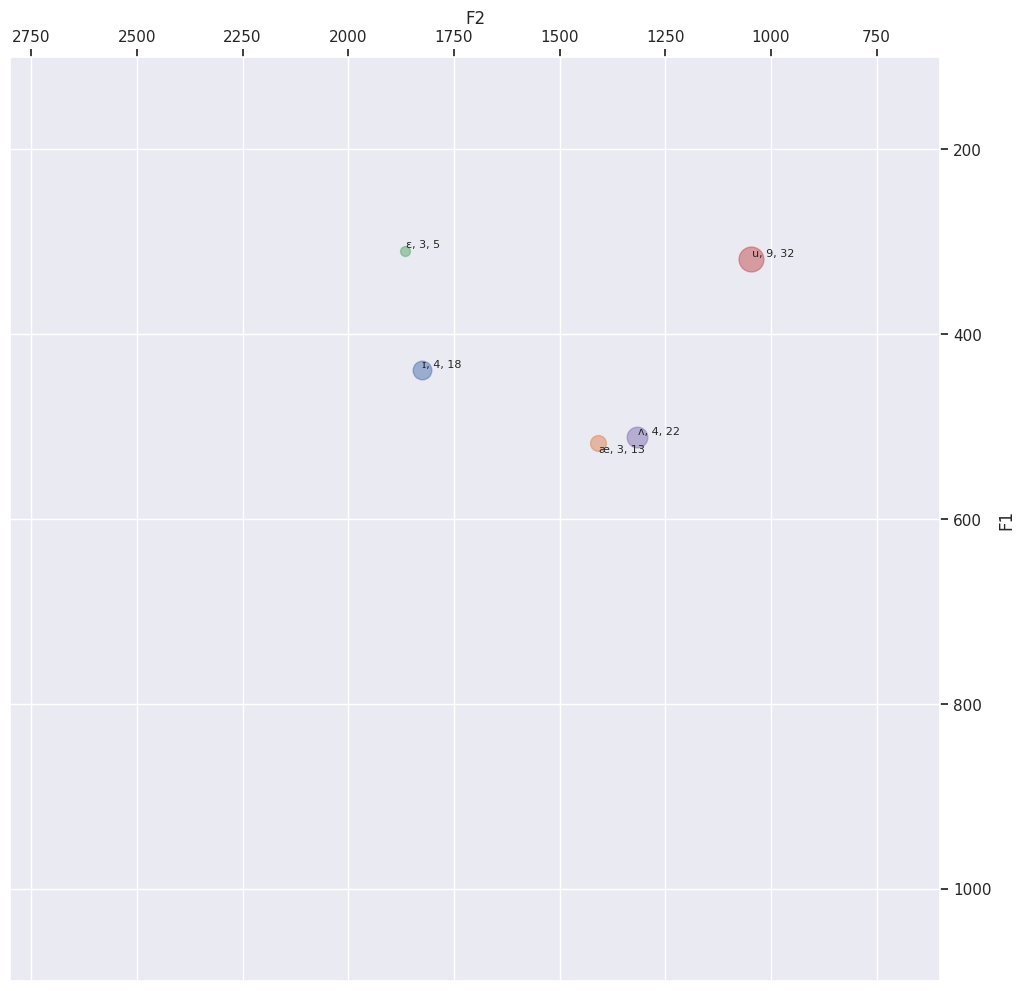

In [ ]:
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme()
from adjustText import adjust_text
from matplotlib import pyplot as plt

from itertools import cycle
fz = []
colors = cycle(['red', 'yellow', 'green','blue','pink','brown','orange'])
fig, ax = plt.subplots(figsize=(12,12))
texts = []
ax = garnish(ax)
df = vowels_df1
for x in ['UH1',  'IH1', 'AE1', 'EH1',
        'UW1', 'AO1', 'AH1',  'AA1', 
         'ER1']:
        #'AY1', 'EY1','IY1', 'AW1','OW1',]:

    if len(df[df["vowel"]==x].file.unique()) > 1:
                            vowels = len(df[df["vowel"]==x].file.unique())
                            msmts = len(df[df["vowel"]==x])
                            pts = np.vstack((df[df["vowel"]==x].groupby("pct")["f2"].mean().values,
                                              df[df["vowel"]==x].groupby("pct")["f1"].mean().values))
                            try:

                                #tck, u = splprep(pts, s=10,k = 2)
                                #u_new = np.linspace(u.min(), u.max(), 1000)
                                #x_new, y_new = splev(u_new, tck)
                                #ax.plot(x_new, y_new, '--')
                                #ax.plot(dg.f2, dg.f1)
                                #ax.scatter(dg.f2.dropna(), dg.f1.dropna(), 
                                #        zorder=1 )
                                #s = InterpolatedUnivariateSpline(dg1.f2.dropna(), dg1.f1.dropna())
                                #xfit = np.arange(dg1.f2.dropna().min(), dg1.f2.dropna().max(), .0003)
                                #yfit = s(xfit)
                                #ax.plot(xfit, yfit)# 'g')#, lw=3, color="red")
                                
                                ax.scatter(df[df["vowel"]==x].groupby("pct")["f2"].mean().values.mean(),
                                                  df[df["vowel"]==x].groupby("pct")["f1"].mean().values.mean(),
                                           s=msmts*10, alpha = .5,
                                        zorder=1 )
                                texts.append(ax.text(df[df["vowel"]==x].groupby("pct")["f2"].mean().values.mean(),
                                        df[df["vowel"]==x].groupby("pct")["f1"].mean().values.mean(),
                                        
                                        arpa2ipa[x]+", "+str(vowels)+", "+str(msmts),
                                        fontdict={'fontsize': 8, 'fontweight': 'medium'}))

                            except:
                                continue
adjust_text(texts)
plt.show(block=False)


In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

/content/phonetics_pipeline/GovernmentZA/audio/DvlexmXK2o8_sentiment so we need to deal with_1.mp4


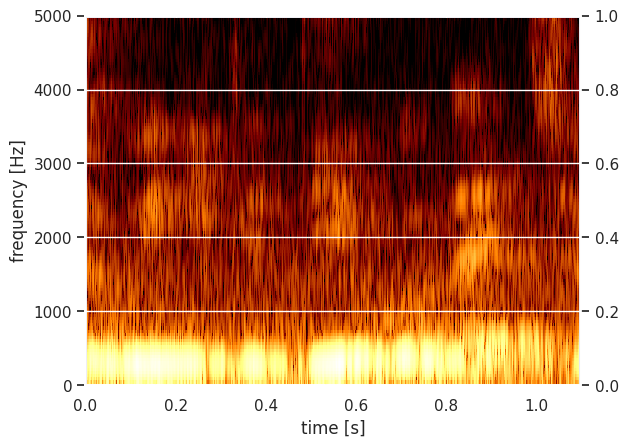

/content/phonetics_pipeline/GovernmentZA/audio/mGV5bCrbhho_sndf so they need to have the_0.mp4


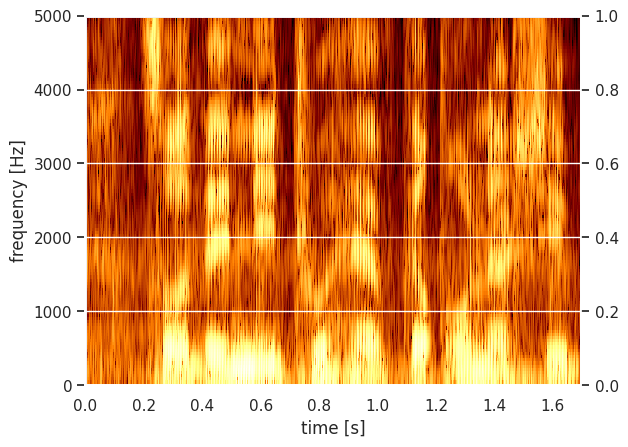

In [ ]:
#intensity = snd.to_intensity()
#
for x in sounds[0:2]:
    snd = parselmouth.Sound(x.replace("mp4","wav"))
    spectrogram = snd.to_spectrogram()
    print(x)
    plt.figure()
    draw_spectrogram(spectrogram)
    plt.twinx()
    #draw_intensity(intensity)
    plt.xlim([snd.xmin, snd.xmax])
    plt.show()